## Extreme Components Analysis - XCA

This is a notebook to illustrate the ideas discussed in the blogpost https://hoyleanalytics.org/2025/06/18/xca/. The ideas and formulae are based on the 2003 NeurIPs paper by Welling et al on Extreme Components Analysis (XCA) - https://papers.nips.cc/paper_files/paper/2003/file/c5dc3e08849bec07e33ca353de62ea04-Paper.pdf

Note: I have used different, more commonly used notation for various dimensions, than that used in the Welling et al paper. The mapping between the two notations is as follows,

|Quantity | My notation | Welling et al notation |
|----|----|----|
| Number of data points | $N$ | $N$ |
| Number of features | $d$ | $D$ |
| Number of components | $k$ | $d$|

To start we'll import the packages that we'll need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Next we'll set the seed for the NumPy pseudo-random number generator (RNG), so that we get reproducible results every time we run the notebook.

In [2]:
# Set the RNG seed
np.random.seed(1729)

Now to generate the simulated data. We first need to set the size of the data we want to generate. In this case I have chosen to generate $N = 2000$ data points, each consisting of $d = 200$ features. The data will be stored in the $N \times d$ matrix $\underline{\underline{X}}$.

Without loss of generality we can choose our true principal component and minor component directions to align with our coordinate axes, i.e. we choose our component basis to be the same as the elements of our NumPy arrays that we use to store the data. So, we'll make the first $k_{PC}$ features the true principal components, the next $k_{MC}$ features the true minor components, and the next $d - k_{PC} - k_{MC}$ features to span the true 'noise' subspace.  

In [3]:
## Generate the data

# 1. Set the data matrix size
d = 200  # The number of features
n = 2000  # The number of datapoints

# 2. Set the number of principal and minor components in the simulated data
k_pc = 10  # The number of true principal components in the data
k_mc = 10  # The number of true minor components in the data

# 3. Create the eigenvalues of the population covariance matrix
sig2 = 20.0  # The variance of the noise directions in the data
lambda_pc = [3.0*sig2*(1.0 + float(i)/float(3*k_pc)) for i in range(k_pc)]
lambda_mc = [sig2*0.1*(1.0 + float(i)/float(k_mc)) for i in range(k_mc)]

# 4. Instantiate the data matrix
x = np.zeros((n,d))

# 5. Generate the data along the principal component directions
for i in range(k_pc):
    x[:, i] = np.sqrt(lambda_pc[i]) * np.random.randn(n)
    
# 6. Generate the data along the minor component directions
for i in range(k_mc):
    x[:, (k_pc+i)] = np.sqrt(lambda_mc[i]) * np.random.randn(n)

# 7. Generate the data along the noise directions
for i in range(k_pc + k_mc, d):
    x[:, i] = np.sqrt(sig2)*np.random.randn(n)

We will explicitly mean center our data matrix - see footnote 1 in blogpost for comment on this.

In [4]:
# Mean centre the data
x_mean = np.mean(x, axis=0)
x_centered = x - np.outer(np.ones(n), x_mean)

Now we have the centered data matrix $\underline{\underline{X_{c}}}$ we can compute the eigenvalues of the sample covariance matrix $\hat{\underline{\underline{C}}}$. The sample covariance is defined as, 

$\hat{\underline{\underline{C}}} = \frac{1}{N-1} \underline{\underline{X_{c}}}^{\top}\underline{\underline{X_{c}}}$. Once we have calculated $\hat{\underline{\underline{C}}}$, we can use the NumPy function numpy.linalg.eigvalsh to compute its eigenvalues because the sample covariance matrix is real and symmetric, which makes it Hermitian.

I will compute $\hat{\underline{\underline{C}}}$ and its eigenvalues in one step, since we won't need to reference $\hat{\underline{\underline{C}}}$ again.

In [5]:
# Compute the eigenvalues of the sample covariance matrix
eigvals = np.linalg.eigvalsh(np.matmul(np.transpose(x_centered), x_centered)/float(n-1))

Now we can take a look at the eigenvalues of the sample covariance matrix. We expect these to follow a similar pattern to the eigenvalues of the population covariance matrix that we used to generate the data, i.e. we expect a small group of noticeably low-valued eigenvalues, a small group of noticeably high-valued eigenvalues, and the bulk (majority) of the eigenvalues to form a continuous spectrum of values.

In the plots below I have plotted all the eigenvalues (sorted from lowest to highest) in the left-hand plot, and I have also zoomed in on just the smallest values (middle plot) and just the largest values (right-hand plot). We can clearly see that the sample covariance eigenvalues follow the pattern we expected.

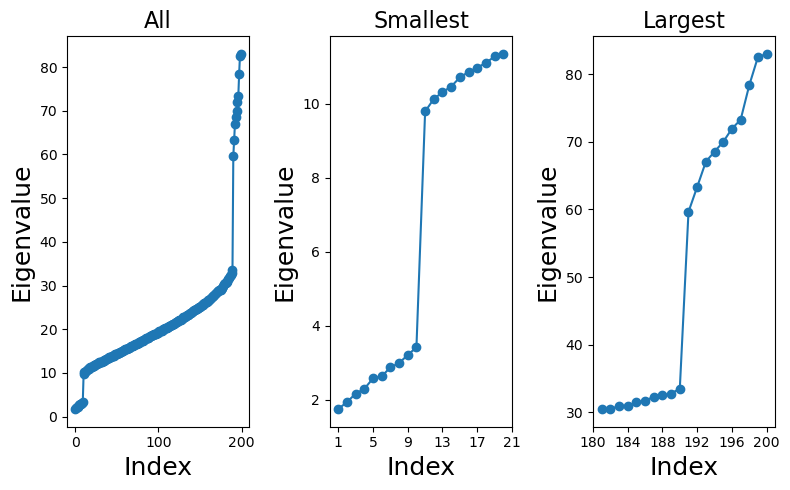

In [6]:
# Plot eigenvalues
plt.figure(figsize=(8,5))

# Plot all the eigenvalues
plt.subplot(1, 3, 1)
plt.plot(eigvals, marker='o')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Eigenvalue', fontsize=18)
plt.title('All', fontsize=16)

# Plot just the smallest eigenvalues.
# This should include all the minor components
plt.subplot(1, 3, 2)
plt.plot(eigvals[0:(2*k_mc)],marker='o')
plt.xticks(np.arange(0, 2*k_mc+1, 4), labels=[str(i) for i in range(1, 2*k_mc+2, 4)])
plt.xlabel('Index', fontsize=18)
plt.ylabel('Eigenvalue', fontsize=18)
plt.title('Smallest', fontsize=16)

# Plot just the largest eigenvalues.
# This should include all the principal components
plt.subplot(1, 3, 3)
plt.plot(eigvals[-(2*k_pc):],marker='o')
plt.xticks(np.arange(-1, 2*k_pc, 4), labels=[str(i) for i in range(d-(2*k_pc), d+1, 4)])
plt.xlabel('Index', fontsize=18)
plt.ylabel('Eigenvalue', fontsize=18)
plt.title('Largest', fontsize=16)

plt.tight_layout()
plt.show()

How many principal components and how many minor components should we retain for this dataset? We'll use the likelihood value at the maximum likelihood solution to do this. Below I've written a function that calculates the ${\cal{K}}$ quantity given on p5 of Welling et al. I've also written another function that loops over the number of possible principal components, $k_{pc}$, for a given fixed total number $k$ of extreme components, and calculates the value of ${\cal{K}}$. The optimal value of $k_{pc}$ is then the value that gives the smallest value of ${\cal{K}}$. 

In [7]:
def neg_loglike(spectrum: np.array, k_pc: int, k_mc: int) -> float:
    
    """Calculates negative log-likelihood.

    Calculates the kappa function of Welling et al, 
    https://papers.nips.cc/paper_files/paper/2003/file/c5dc3e08849bec07e33ca353de62ea04-Paper.pdf
    This is the negative log-likelihood (up to an irrelvant constant and scale)
    at the maximum likelihood point

    Args:
        spectrum: The sample covariance eigenvalues.
          A 1D NumPy array 
        k_pc: The number of principal components retained.
          A non-negative int.
        k_mc: The number of minor components retained.
          A non-negative int

    Returns:
        kappa: The kappa value of Welling et al. This
          is the negative log-likelihood (up to an irrelevant
          constant) of the maximum likelihood extreme components
          estimates for the given number of principal and minor
          components. The returned value is a float
    """    

    # Extract the number of features. This is implicit in the
    # number of eigenvalues
    d = spectrum.size
    
    # Take a copy of the eigenvalues and sort them from lowest
    # to highest
    spectrum_tmp = np.sort(spectrum)
    
    # Compute the kappa value
    kappa = np.sum(np.log(spectrum_tmp[0:k_pc]))
    kappa += np.sum(np.log(spectrum_tmp[-k_mc:]))
    sum_retained = np.sum(spectrum_tmp[0:k_pc]) + np.sum(spectrum_tmp[-k_mc:])
    kappa += float(d - k_pc - k_mc)*np.log(np.sum(spectrum_tmp) - sum_retained)
    
    return kappa

def optimal_kpc(spectrum: np.array, k: int) -> tuple:
    
    """Calculates optimal number of principal components.

    Calculates the optimal number of principal components 
    from the sample covariance matrix eigenvalue spectrum 
    and for a given number of extreme components (principal
    components + minor components)

    Args:
        spectrum: The sample covariance eigenvalues.
          A 1D NumPy array 
        k: The total number of extreme components retained.
          A non-negative int.

    Returns:
        A tuple consisting of the optimal number of 
        principal components and the corresponding 
        kappa value
    """ 

    # Initialize values for the optimal number
    # of principal components and the corresponding 
    # kappa value
    kappa_min = 0.0
    k_pc_min = 0
    
    # Loop over the possible values for the
    # number of principal components
    for k_pc in range(0, k):
        kappa = neg_loglike(spectrum, k_pc, k-k_pc)
        
        # If this is the first iteration then 
        # store this as the minimum kappa value
        if k_pc == 0:
            kappa_min = kappa
            k_pc_min = 1
        else:
            # If kappa value is lower than 
            # current minimum, then update minimum
            if kappa < kappa_min:
                kappa_min = kappa
                k_pc_min = k_pc
                
    return k_pc_min, kappa_min

We can apply the optimal_kpc function defined above to the our sample covariance eigenvalues. We do that below.

In [8]:
# Set the number extreme components we want.
# In this case I will use 20 (the true value)
kxc = 20

# Calculate the optimal number of principal components given the number of extreme components
kpc_optimal, kappa_optimal = optimal_kpc(spectrum = eigvals, k = kxc)
print("The optimal number of principal components selected = " + str(kpc_optimal))
print("The optimal number of minor components selected = " + str(kxc - kpc_optimal))

The optimal number of principal components selected = 10
The optimal number of minor components selected = 10


We can see that the XCA algorithm has selected the correct number of principal components (and hence also the correct number of minor components). This was an easy example we gave the XCA algorithm, but it was deliberately designed that way so that we could easily illustrate the algorithm. See the end of the blogpost for comments on the some of the challenges in selecting low-dimensional subspaces in real data.